# Import needed modules

In [74]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# Create needed functions

## Functions to Create Data Frame from Dataset

#### **Function to create data frame**

In [75]:
# Generate data paths with labels
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            if fold == '1':
                labels.append('meningioma')
            elif fold == '2':
                labels.append('glioma')
            elif fold == '3':
                labels.append('pituitary tumor')

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)


# Split dataframe to train, valid, and test
def create_df(data_dir):
    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

#### Function to generate images from dataframe

In [76]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

#### **Function to display data sample**

In [77]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

#### **Function to plot value counts for a column in a dataframe**

In [78]:
def plot_label_count(df, plot_title):
    '''
    This function take df and plot labels value counts
    '''

    # Define needed variables
    vcounts = df['labels'].value_counts()
    labels = vcounts.keys().tolist()
    values = vcounts.tolist()
    lcount = len(labels)

    if lcount > 55:
        print('The number of labels is > 55, no plot will be produced')

    else:
        plot_labels(lcount, labels, values, plot_title)

def plot_labels(lcount, labels, values, plot_title):
    width = lcount * 4
    width = np.min([width, 20])

    plt.figure(figsize= (width, 5))

    form = {'family': 'serif', 'color': 'blue', 'size': 25}
    sns.barplot(x=labels, y=values)
    plt.title(f'Images per Label in {plot_title} data', fontsize= 24, color= 'blue')
    plt.xticks(rotation= 90, fontsize= 18)
    plt.yticks(fontsize= 18)
    plt.xlabel('CLASS', fontdict= form)
    yaxis_label = 'IMAGE COUNT'
    plt.ylabel(yaxis_label, fontdict= form)

    rotation = 'vertical' if lcount >= 8 else 'horizontal'
    for i in range(lcount):
        plt.text(i, values[i] / 2, str(values[i]), fontsize= 12,
                rotation= rotation, color= 'yellow', ha= 'center')

    plt.show()

#### **Callbacks** 
<br> 
Callbacks : Helpful functions to help optimize model training  <br> 
Examples: stop model training after specfic time, stop training if no improve in accuracy and so on.

In [79]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights)


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch

            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer

                else:
                    self.count = self.count + 1 # increment the patience counter

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')

#### **Function to plot history of training**

In [80]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()


#### **Function to create Confusion Matrix**

In [81]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	'''
	This function plot confusion matrix method from sklearn package.
	'''

	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

# **Model Structure**

#### **Start Reading Dataset**

In [82]:
data_dir = '/kaggle/input/brain-tumor'

try:
    # Get splitted data
    train_df, valid_df, test_df = create_df(data_dir)

    # Get Generators
    batch_size = 40
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except:
    print('Invalid Input')

Found 2451 validated image filenames belonging to 3 classes.
Found 306 validated image filenames belonging to 3 classes.
Found 307 validated image filenames belonging to 3 classes.


#### **Display Image Sample**

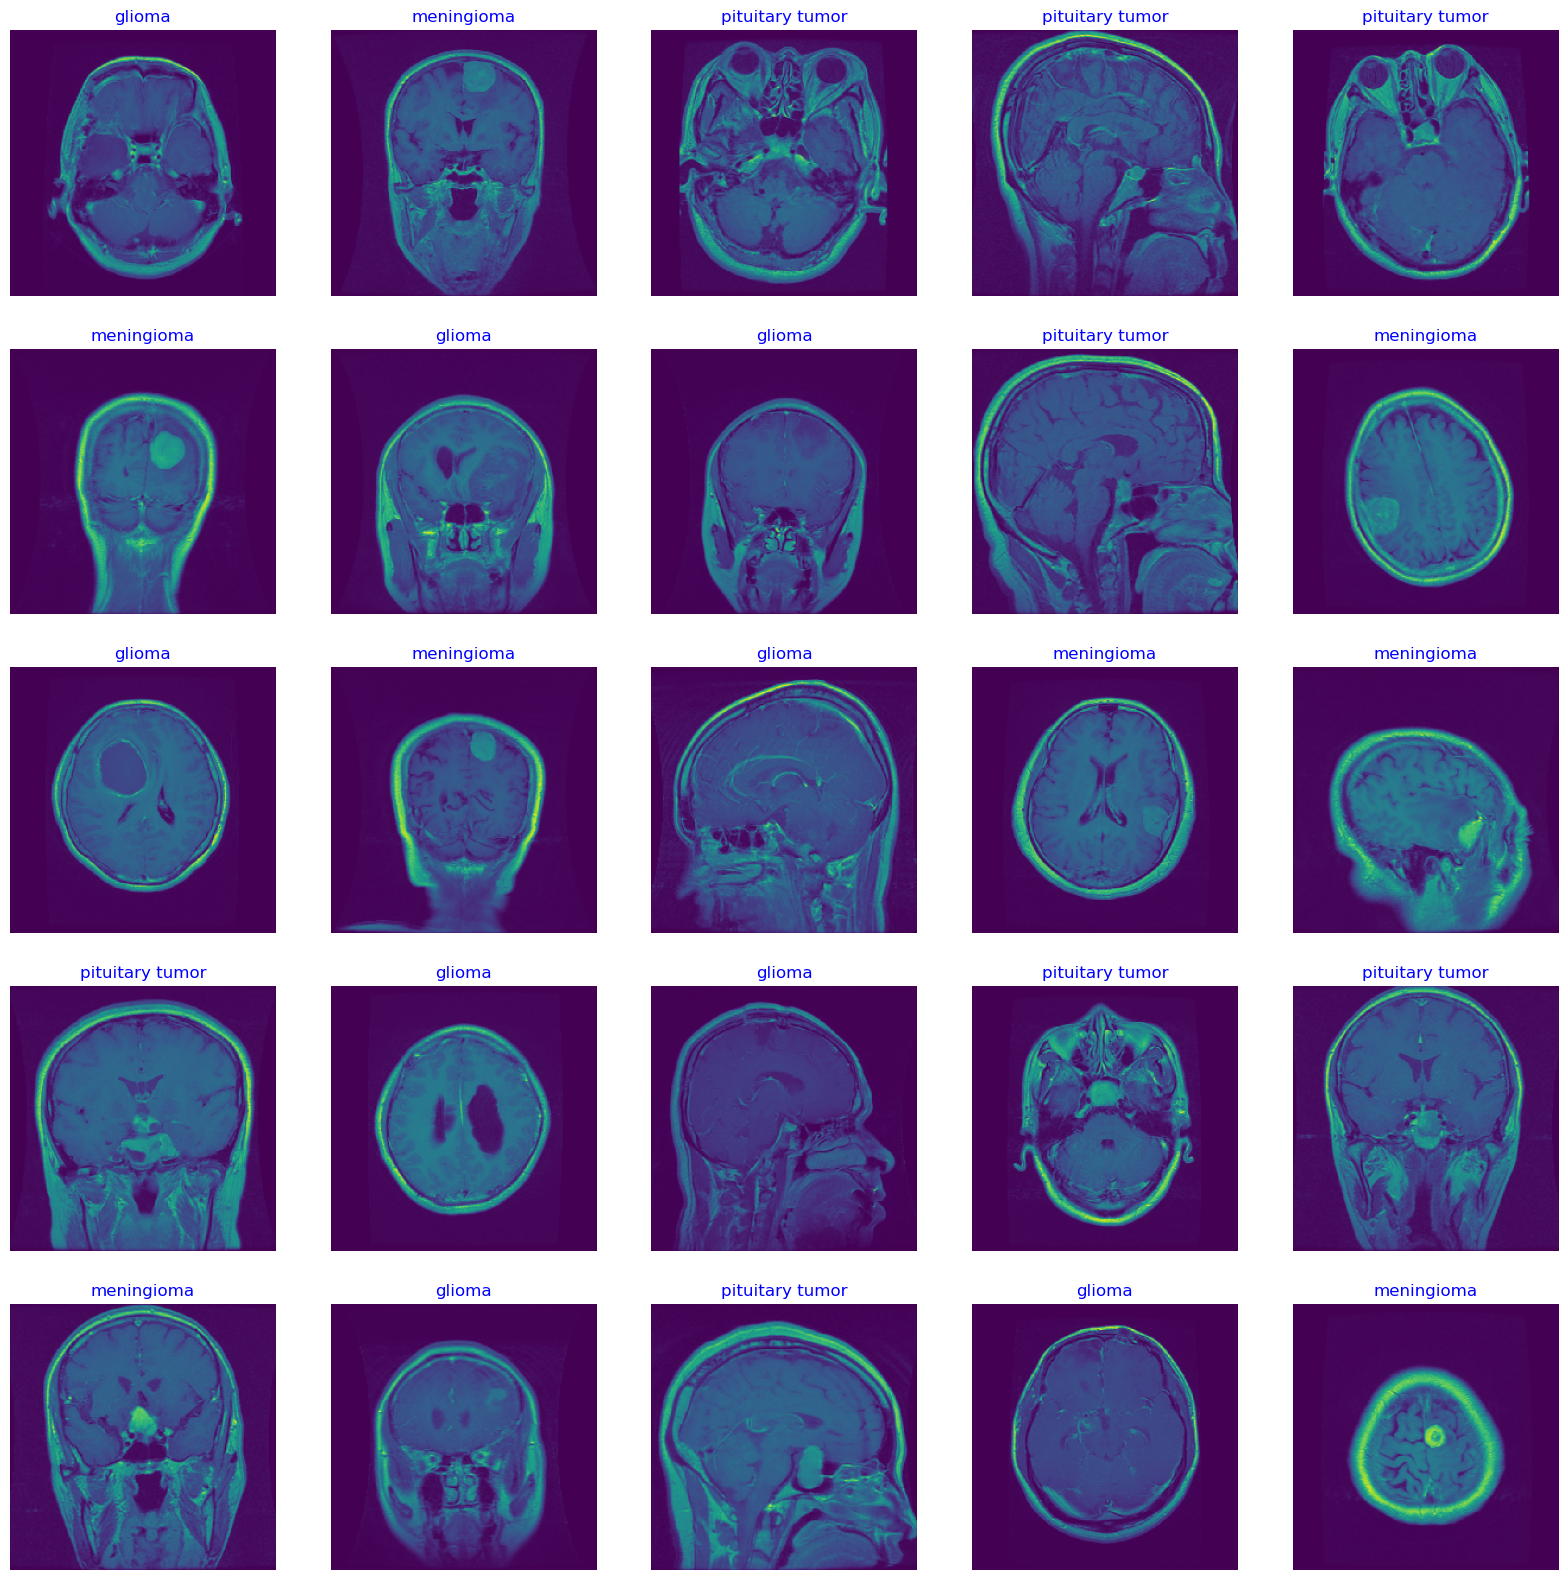

In [83]:
show_images(train_gen)

#### **Show Labels Count**

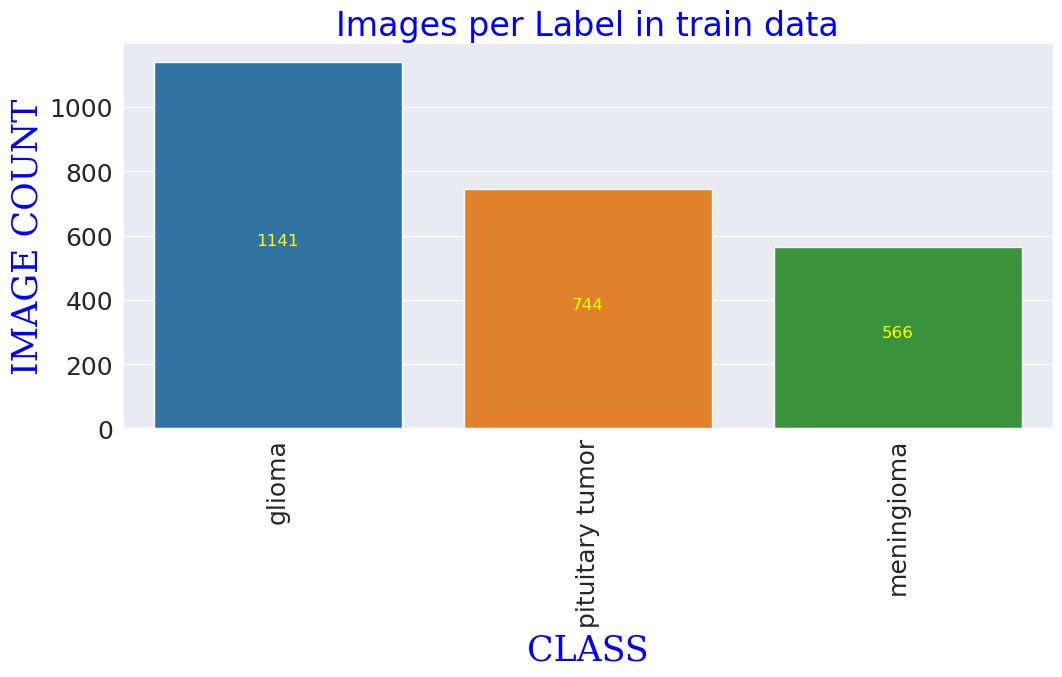

In [84]:
plot_label_count(train_df, 'train')

#### **Generic Model Creation**

In [85]:
from tensorflow.keras.applications import EfficientNetB0, ResNet50, VGG16


In [86]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras.applications import EfficientNetB0, ResNet50, VGG16

# Define the input shape
input_shape = (224, 224, 3)
class_count = len(list(train_gen.class_indices.keys()))
model_input = Input(shape=input_shape)

# Load various pre-trained models
# Load various pre-trained models
def load_base_model(model_name, input_shape):
    if model_name == "Xception":
        return tf.keras.applications.Xception(include_top=False, weights="imagenet", input_shape=input_shape)(model_input)
    if model_name == "EfficientNetB0":
        return EfficientNetB0(include_top=False, weights="imagenet", input_shape=input_shape)(model_input)
    if model_name == "ResNet50":
        return ResNet50(include_top=False, weights="imagenet", input_shape=input_shape)(model_input)

#     if model_name == "VGG16":
#         return VGG16(include_top=False, weights="imagenet", input_shape=input_shape, pooling='max')(model_input)

# Load all base models
xception_base = load_base_model("Xception", input_shape)
efficientnet_base = load_base_model("EfficientNetB0", input_shape)
resnet_base = load_base_model("ResNet50", input_shape)
# vgg_base = load_base_model("VGG16", input_shape)

# Combine the outputs of the base models
# combined = concatenate([xception_base, efficientnet_base, resnet_base])

from tensorflow.keras.layers import Conv2D, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D

# Combine the outputs of the base models
combined = concatenate([xception_base, efficientnet_base, resnet_base])

# Add a top convolutional layer (Top_Conv_Layer)
x = Conv2D(64, (3, 3), padding='same', activation='relu', name='Top_Conv_Layer')(combined)
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)

# Apply Global Average Pooling after the Conv2D layer
x = GlobalAveragePooling2D()(x)

# Add fully connected layers
x = Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=0.45, seed=123)(x)

# Final output layer
output = Dense(class_count, activation='softmax')(x)

# Create the ensemble model
ensemble_model = Model(inputs=model_input, outputs=output)

# Compile the model
ensemble_model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Show the model summary
ensemble_model.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 xception (Functional)          (None, 7, 7, 2048)   20861480    ['input_21[0][0]']               
                                                                                                  
 efficientnetb0 (Functional)    (None, 7, 7, 1280)   4049571     ['input_21[0][0]']               
                                                                                                  
 resnet50 (Functional)          (None, 7, 7, 2048)   23587712    ['input_21[0][0]']         

In [87]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import plotly.graph_objects as go
import plotly.express as px
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import callbacks
import seaborn as sns
from skimage.io import imread, imsave
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow.keras.backend as K
import tensorflow_hub as hub
import matplotlib.image as img

In [88]:
Model_1=ensemble_model

In [93]:
ensemble_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 xception (Functional)          (None, 7, 7, 2048)   20861480    ['input_21[0][0]']               
                                                                                                  
 efficientnetb0 (Functional)    (None, 7, 7, 1280)   4049571     ['input_21[0][0]']               
                                                                                                  
 resnet50 (Functional)          (None, 7, 7, 2048)   23587712    ['input_21[0][0]']         

#### **Set Callback Parameters**

In [95]:
# Set callback parameters
batch_size = 20   # set batch size for training
epochs = 40   # number of all epochs in training
patience = 1   #number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3   # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9   # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5   # factor to reduce lr by
ask_epoch = 5   # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

callbacks = [MyCallback(model= ensemble_model, patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch )]


#### **Train model**

In [100]:
# Train model
history = ensemble_model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)


Do you want model asks you to halt the training [y/n] ?


 y


 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration


2024-10-17 17:51:40.560822: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 1 /40     1.772   89.678   2.64061  61.438   0.00100  0.00100  accuracy     0.00    177.05 
 2 /40     1.070   97.062   0.93826  96.405   0.00100  0.00100  val_loss    64.47    64.31  
 3 /40     0.725   98.939   0.69597  95.098   0.00100  0.00100  val_loss    25.82    64.10  
 4 /40     0.522   99.347   0.49132  97.386   0.00100  0.00100  val_loss    29.40    64.23  
 5 /40     0.392   99.510   0.37695  97.386   0.00100  0.00100  val_loss    23.28    64.18  
enter H to halt training or an integer for number of epochs to run then ask again


 30


 training will continue until epoch 35
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 6 /40     0.311   99.510   0.32042  97.712   0.00100  0.00100  val_loss    15.00    64.15  
 7 /40     0.248   99.796   0.25464  98.366   0.00100  0.00100  val_loss    20.53    64.12  
 8 /40     0.207   99.796   0.24368  98.039   0.00100  0.00100  val_loss     4.31    64.54  
 9 /40     0.186   99.674   0.24450  96.405   0.00100  0.00050  val_loss    -0.34    64.33  
10 /40     0.166   99.837   0.22929  96.078   0.00050  0.00050  val_loss     5.91    64.37  
11 /40     0.153   99.878   0.18408  97.386   0.00050  0.00050  val_loss    19.72    64.33  
12 /40     0.145   99.959   0.17569  98.039   0.00050  0.00050  val_loss     4.56    64.36  
13 /40     0.137   99.959   0.16717  97.712   0.00050  0.00050  val_loss     4.85    64.41  
14 /40     0.136   99.796   0.15954  98.366   0.00050  0.00050  val_loss     4.57    64.30  
15 /40     0.126   99.959   0.15

#### **Display model performance**

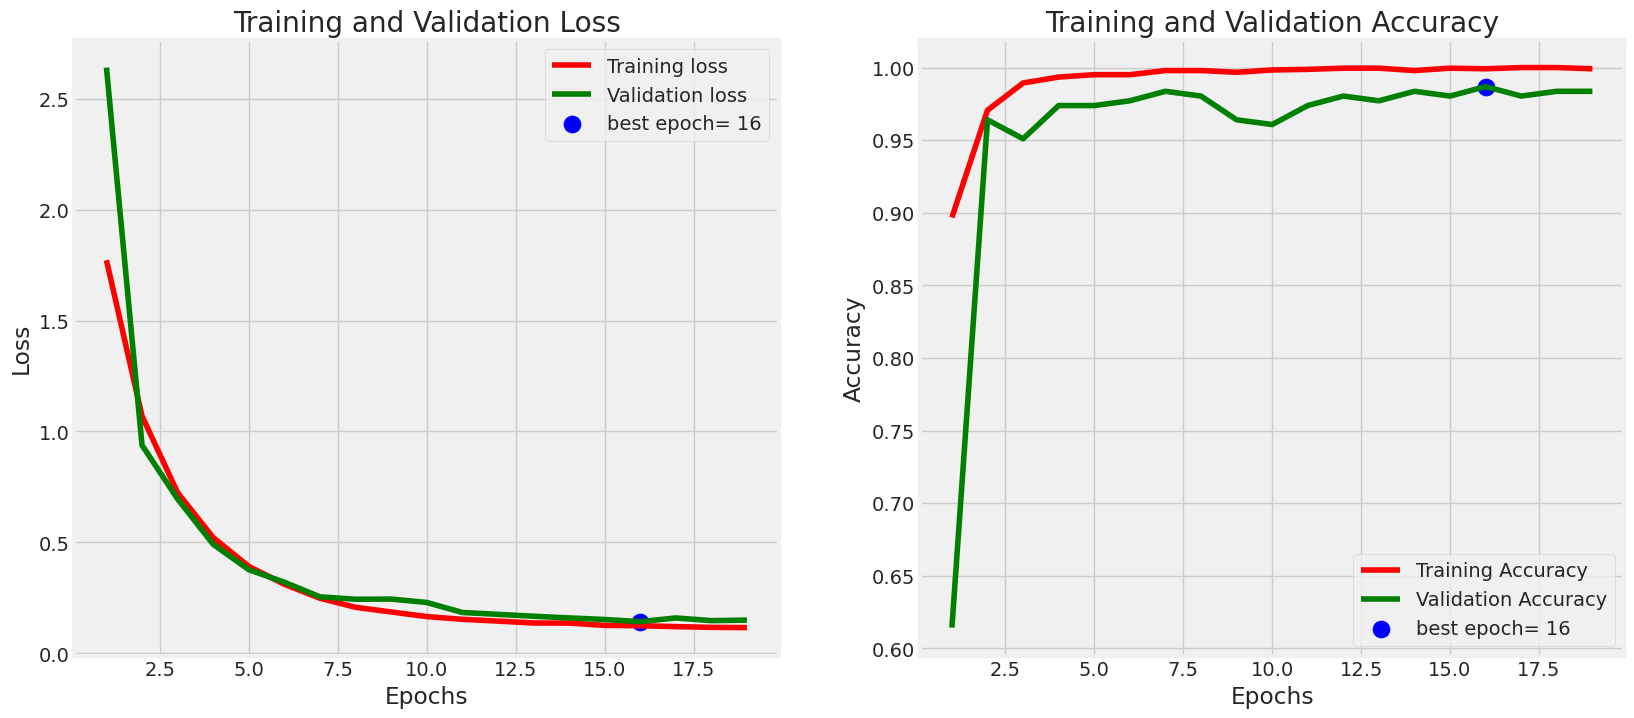

In [101]:
plot_training(history)

# **Evaluate model**

In [102]:
# Evaluate model
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
test_steps = ts_length // test_batch_size

train_score = ensemble_model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = ensemble_model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = ensemble_model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


307/307 [==============================] - 10s 34ms/step - loss: 0.1772 - accuracy: 0.9805
Train Loss:  0.10625279694795609
Train Accuracy:  1.0
--------------------
Validation Loss:  0.14276817440986633
Validation Accuracy:  0.9869281053543091
--------------------
Test Loss:  0.17722736299037933
Test Accuracy:  0.9804560542106628


# **Get Predictions**

In [103]:
# Get predictions
preds = ensemble_model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)


307/307 [==============================] - 13s 31ms/step
[1 1 0 0 2 0 2 2 0 1 1 2 0 0 1 0 0 0 1 2 1 0 2 2 2 0 0 2 0 0 0 1 0 1 2 2 1
 0 0 0 0 1 2 2 2 1 2 2 2 0 0 2 0 2 0 2 2 0 1 1 2 0 2 2 1 1 2 1 0 0 1 0 1 2
 0 2 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 2 0 0 2 2 2 0 2 0 2 0 0 0 0 1 2 2 0 0
 2 0 0 2 0 2 2 0 0 0 0 1 0 0 2 2 0 1 0 0 0 0 0 0 1 2 1 0 0 1 0 1 0 0 0 0 2
 1 0 2 2 0 0 2 2 0 0 2 2 0 0 1 0 2 0 1 0 2 2 1 0 2 0 0 1 0 1 0 1 0 0 1 2 2
 2 1 0 0 2 0 2 0 2 2 0 2 2 2 0 1 2 1 2 1 2 0 0 0 1 2 0 1 0 2 2 2 0 2 0 1 0
 0 1 2 1 0 2 0 1 0 0 0 2 0 1 1 1 1 0 1 1 0 0 2 2 2 2 2 0 0 0 0 1 1 0 1 1 0
 1 2 0 0 0 0 2 1 0 0 1 0 0 1 0 1 0 1 2 2 0 0 0 1 0 2 1 1 1 0 1 2 2 0 0 0 1
 0 2 0 1 0 2 2 2 0 2 2]


#### **Confusion Matrics and Classification Report**

Confusion Matrix, Without Normalization
[[141   2   0]
 [  3  68   0]
 [  0   1  92]]
                 precision    recall  f1-score   support

         glioma       0.98      0.99      0.98       143
     meningioma       0.96      0.96      0.96        71
pituitary tumor       1.00      0.99      0.99        93

       accuracy                           0.98       307
      macro avg       0.98      0.98      0.98       307
   weighted avg       0.98      0.98      0.98       307



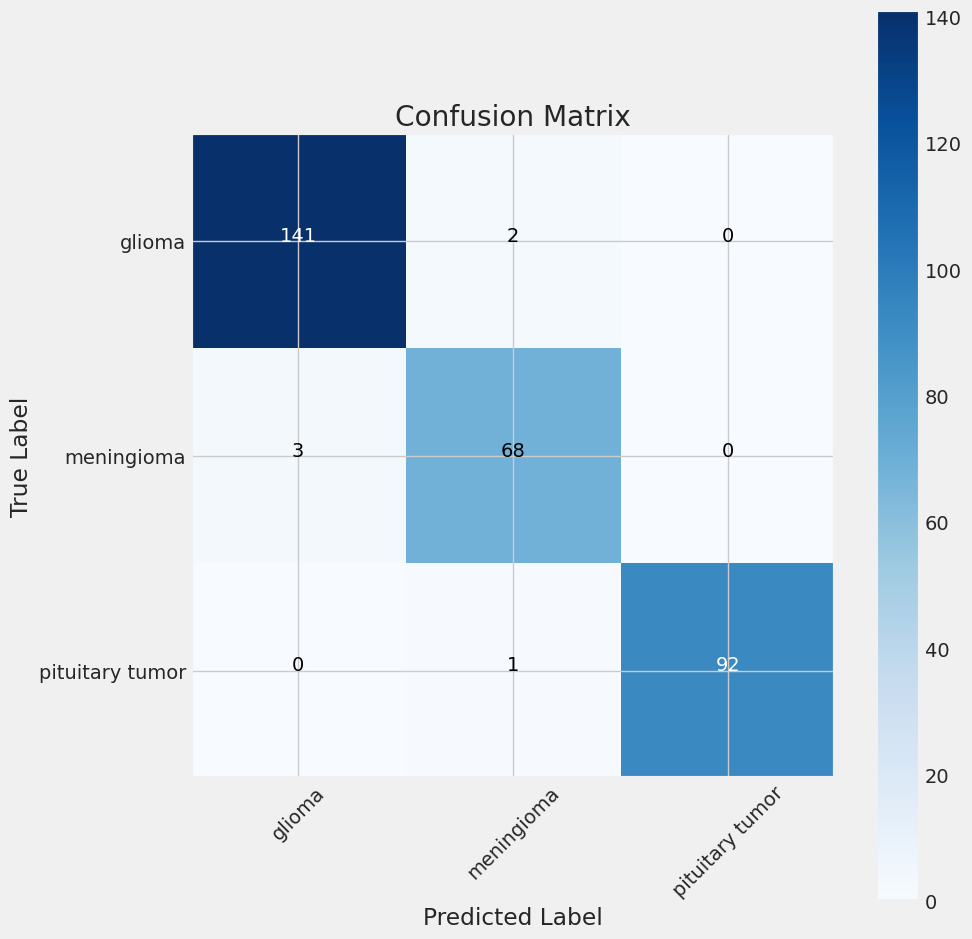

In [104]:
# Confusion matrix and classification report
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title='Confusion Matrix')

print(classification_report(test_gen.classes, y_pred, target_names= classes))


#### **Save model**

In [107]:
# model_name = ensemble_model.input_names[0][:-6]
subject = 'Brain Tumors'
# acc = test_score[1] * 100
save_path = ''

# # Save model
# save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
# model_save_loc = os.path.join(save_path, save_id)
# ensemble_model.save(model_save_loc)
# print(f'model was saved as {model_save_loc}')

# # Save weights
# weight_save_id = str(f'{model_name}-{subject}-weights.h5')
# weights_save_loc = os.path.join(save_path, weight_save_id)
# model.save_weights(weights_save_loc)
# print(f'weights were saved as {weights_save_loc}')

#### **Generate CSV files containing classes indicies & image size**

In [108]:
# Generate CSV files containing classes indices & image size
class_dict = train_gen.class_indices
img_size = train_gen.image_shape
height = []
width = []
for _ in range(len(class_dict)):
    height.append(img_size[0])
    width.append(img_size[1])

Index_series = pd.Series(list(class_dict.values()), name= 'class_index')
Class_series = pd.Series(list(class_dict.keys()), name= 'class')
Height_series = pd.Series(height, name= 'height')
Width_series = pd.Series(width, name= 'width')
class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis= 1)
csv_name = f'{subject}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index= False)
print(f'class csv file was saved as {csv_save_loc}')


class csv file was saved as Brain Tumors-class_dict.csv


307/307 [==============================] - 9s 29ms/step
Accuracy: 0.9805
Precision: 0.9805
Recall: 0.9805
F1 Score: 0.9805
Confusion Matrix, Without Normalization
[[141   2   0]
 [  3  68   0]
 [  0   1  92]]
RMSE: 0.1398
MAE: 0.0195
R-squared: 0.9737
Adjusted R-squared: 0.9727
MSE: 0.0195
Log Loss: 0.0850
MCC: 0.9693
Jaccard Index: 0.9620
Cohen's Kappa: 0.9693
Cross-Entropy Loss: 0.0850
Hamming Loss: 0.0195


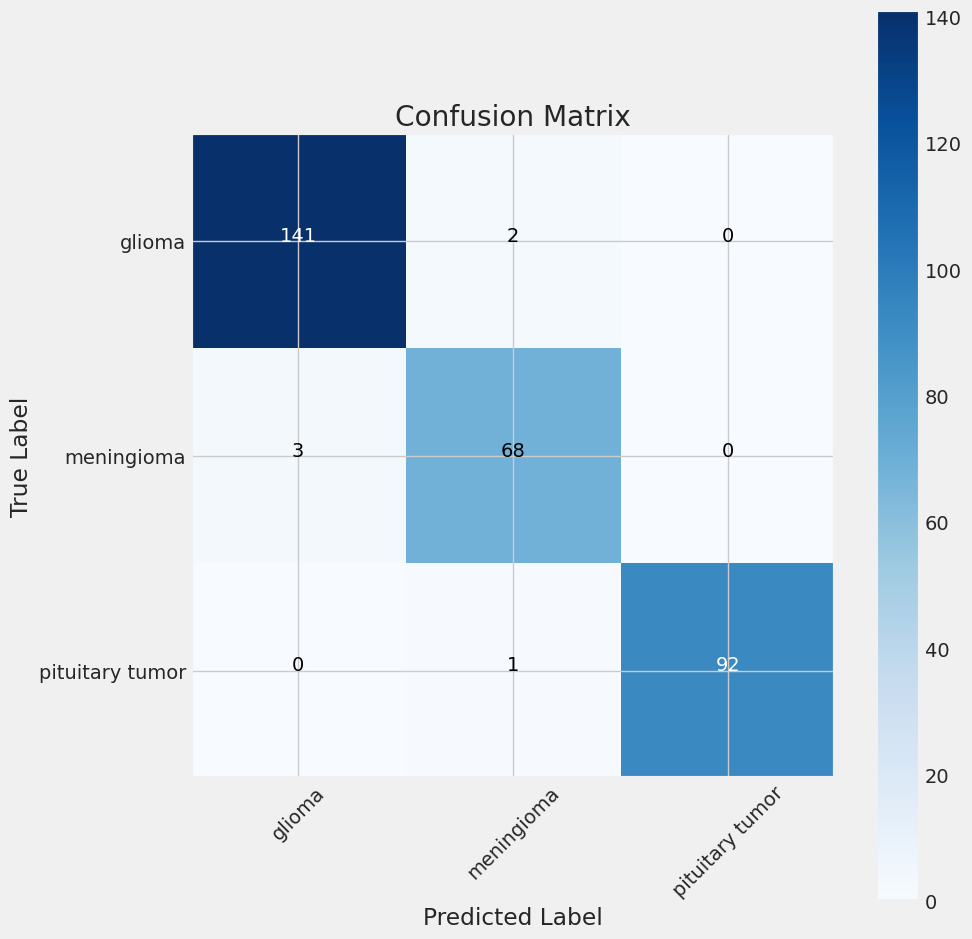

In [109]:
# Required Imports for Metrics Calculation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error, r2_score, log_loss, matthews_corrcoef
from sklearn.metrics import jaccard_score, silhouette_score, cohen_kappa_score, hamming_loss
from sklearn.preprocessing import label_binarize

# Get predictions and true labels from the test set
y_true = test_gen.classes  # True labels
y_pred_probs = ensemble_model.predict(test_gen)  # Predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted labels (classification)

# Calculate Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Calculate Precision
precision = precision_score(y_true, y_pred, average='weighted')
print(f"Precision: {precision:.4f}")

# Calculate Recall (Sensitivity)
recall = recall_score(y_true, y_pred, average='weighted')
print(f"Recall: {recall:.4f}")

# Calculate F1 Score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

# Calculate AUC (for binary or multilabel classification)
if len(classes) == 2:
    auc = roc_auc_score(y_true, y_pred_probs[:, 1])
    print(f"AUC: {auc:.4f}")

# ROC Curve (for binary classification)
if len(classes) == 2:
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs[:, 1])
    plt.plot(fpr, tpr)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, classes, title="Confusion Matrix")

# RMSE (for regression tasks)
rmse = mean_squared_error(y_true, y_pred, squared=False)
print(f"RMSE: {rmse:.4f}")

# MAE (for regression tasks)
mae = mean_absolute_error(y_true, y_pred)
print(f"MAE: {mae:.4f}")

# R-squared (for regression tasks)
r2 = r2_score(y_true, y_pred)
print(f"R-squared: {r2:.4f}")

# Adjusted R-squared (custom calculation for regression tasks)
n = len(y_true)  # Number of samples
p = len(ensemble_model.layers)  # Number of predictors/features
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f"Adjusted R-squared: {adjusted_r2:.4f}")

# MSE (Mean Squared Error)
mse = mean_squared_error(y_true, y_pred)
print(f"MSE: {mse:.4f}")

# Logarithmic Loss (LogLoss)
logloss = log_loss(y_true, y_pred_probs)
print(f"Log Loss: {logloss:.4f}")

# Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_true, y_pred)
print(f"MCC: {mcc:.4f}")

# Jaccard Index
jaccard = jaccard_score(y_true, y_pred, average='weighted')
print(f"Jaccard Index: {jaccard:.4f}")

# Silhouette Score (for clustering)
# This is just a placeholder, as clustering isn't included here

# Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa: {kappa:.4f}")

# Cross-Entropy Loss
cross_entropy_loss = log_loss(y_true, y_pred_probs)
print(f"Cross-Entropy Loss: {cross_entropy_loss:.4f}")

# Hamming Loss
hamming = hamming_loss(y_true, y_pred)
print(f"Hamming Loss: {hamming:.4f}")

# True Positive Rate (TPR) or Sensitivity is already covered by Recall

# False Positive Rate (FPR) can be extracted from ROC Curve
if len(classes) == 2:
    print(f"False Positive Rate (FPR): {fpr:.4f}")

# # Specificity (True Negative Rate)
# tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
# specificity = tn / (tn + fp)
# print(f"Specificity: {specificity:.4f}")


In [110]:
def plot_line_chart(history):
    # Plot training & validation accuracy and loss values
    plt.figure(figsize=(12, 6))
    
    # Accuracy Line Chart
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    # Loss Line Chart
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.show()


In [111]:
def plot_bar_chart(metrics):
    categories = ['Precision', 'Recall', 'F1-Score']
    values = [metrics['precision'], metrics['recall'], metrics['f1_score']]
    
    plt.figure(figsize=(8, 5))
    plt.bar(categories, values, color='skyblue')
    plt.title('Performance Metrics')
    plt.ylabel('Score')
    plt.show()


In [112]:
def plot_stacked_bar_chart(class_report):
    df = pd.DataFrame(class_report).iloc[:-1, :3].T
    df.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='coolwarm')
    plt.title('Classification Report (Precision, Recall, F1-Score)')
    plt.ylabel('Scores')
    plt.xlabel('Metrics')
    plt.show()


In [113]:
def plot_histogram(pred_probs):
    plt.figure(figsize=(8, 5))
    plt.hist(pred_probs, bins=20, color='green', alpha=0.7)
    plt.title('Distribution of Predicted Probabilities')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.show()


In [114]:
def plot_pie_chart(y_true):
    class_counts = np.bincount(y_true)
    class_labels = ['Class 1', 'Class 2', 'Class 3']  # Adjust for the actual class names
    plt.figure(figsize=(7, 7))
    plt.pie(class_counts, labels=class_labels, autopct='%1.1f%%', colors=['lightcoral', 'skyblue', 'lightgreen'])
    plt.title('Class Distribution')
    plt.show()


In [115]:
def plot_pie_chart(y_true):
    class_counts = np.bincount(y_true)
    class_labels = ['Class 1', 'Class 2', 'Class 3']  # Adjust for the actual class names
    plt.figure(figsize=(7, 7))
    plt.pie(class_counts, labels=class_labels, autopct='%1.1f%%', colors=['lightcoral', 'skyblue', 'lightgreen'])
    plt.title('Class Distribution')
    plt.show()


In [116]:
def plot_box_plot(y_pred):
    plt.figure(figsize=(8, 5))
    sns.boxplot(y=y_pred)
    plt.title('Box Plot of Predicted Labels')
    plt.show()


In [117]:
def plot_violin_plot(y_true, y_pred):
    plt.figure(figsize=(8, 6))
    sns.violinplot(data=[y_true, y_pred])
    plt.title('Violin Plot: True vs Predicted Labels')
    plt.xticks([0, 1], ['True Labels', 'Predicted Labels'])
    plt.show()


In [118]:
def plot_scatter_plot(history):
    plt.figure(figsize=(8, 6))
    plt.scatter(history.history['accuracy'], history.history['loss'], color='orange', alpha=0.6)
    plt.title('Scatter Plot of Accuracy vs Loss')
    plt.xlabel('Accuracy')
    plt.ylabel('Loss')
    plt.show()


In [119]:
def plot_bubble_chart(class_report, sample_sizes):
    plt.figure(figsize=(8, 6))
    precision = class_report['precision']
    recall = class_report['recall']
    f1_score = class_report['f1_score']
    
    plt.scatter(precision, recall, s=sample_sizes, alpha=0.5, color='purple')
    plt.title('Bubble Chart: Precision vs Recall with F1-Scores')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.show()


In [120]:
def plot_heatmap(cm, classes):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix Heatmap')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


In [121]:
def plot_correlation_matrix(df):
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')
    plt.show()


In [122]:
def plot_roc_curve(y_true, y_pred_probs):
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label='ROC Curve')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()


In [123]:
def plot_precision_recall_curve(y_true, y_pred_probs):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='red', label='Precision-Recall Curve')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()


In [124]:
def plot_area_chart(history):
    cumulative_acc = np.cumsum(history.history['accuracy'])
    plt.figure(figsize=(8, 6))
    plt.fill_between(range(len(cumulative_acc)), cumulative_acc, color='lightblue')
    plt.title('Cumulative Accuracy (Area Chart)')
    plt.xlabel('Epoch')
    plt.ylabel('Cumulative Accuracy')
    plt.show()


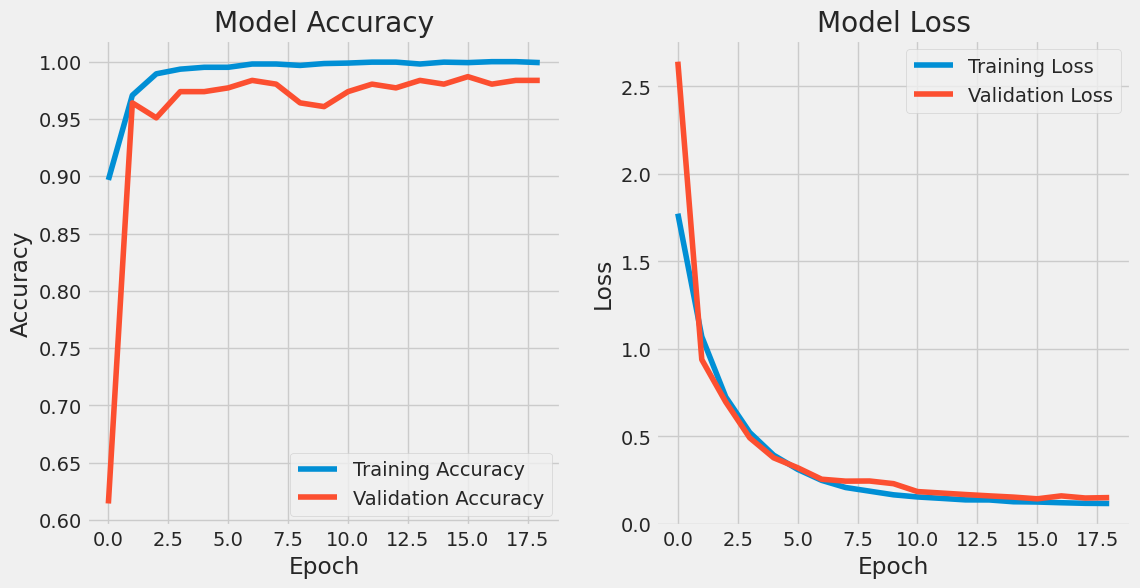

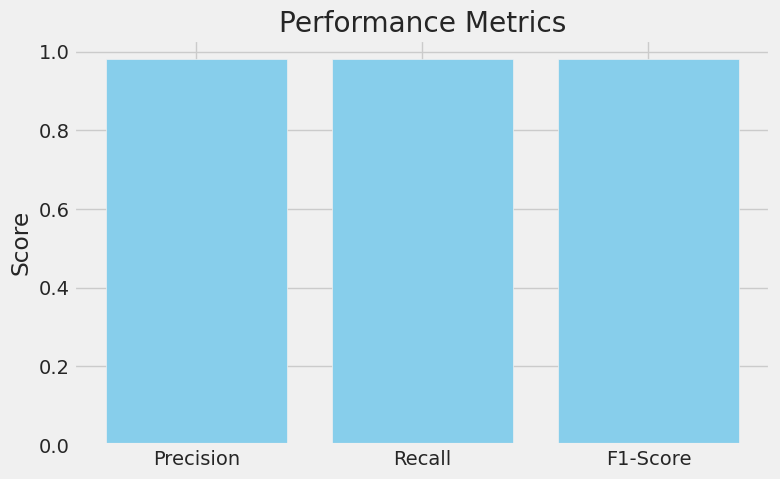

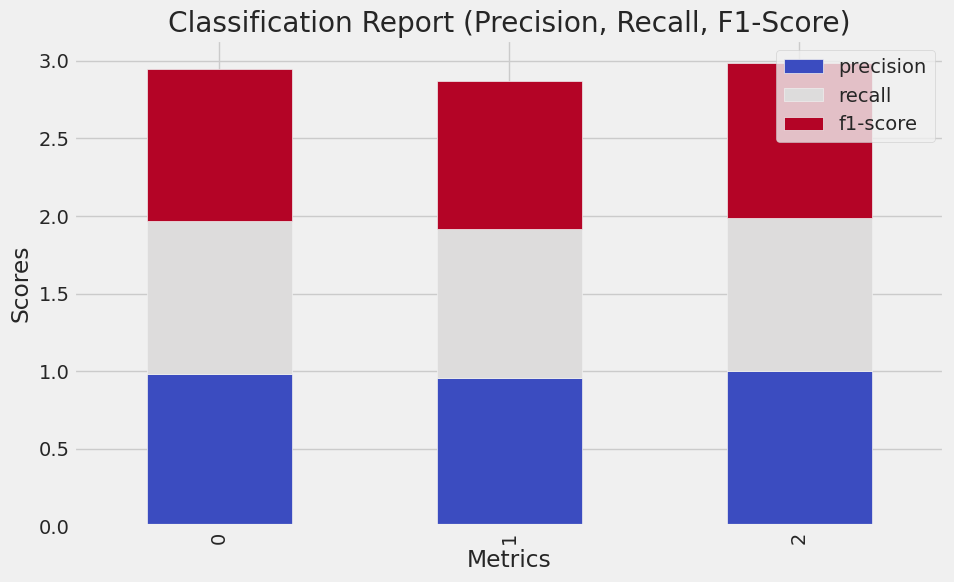

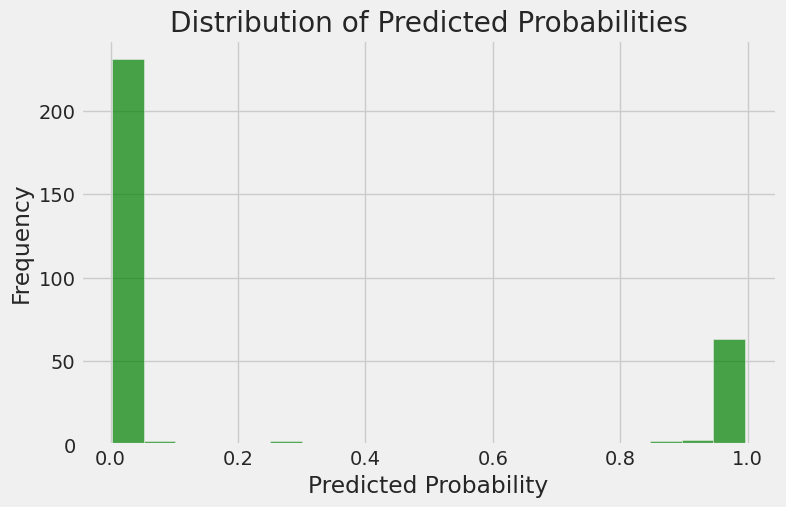

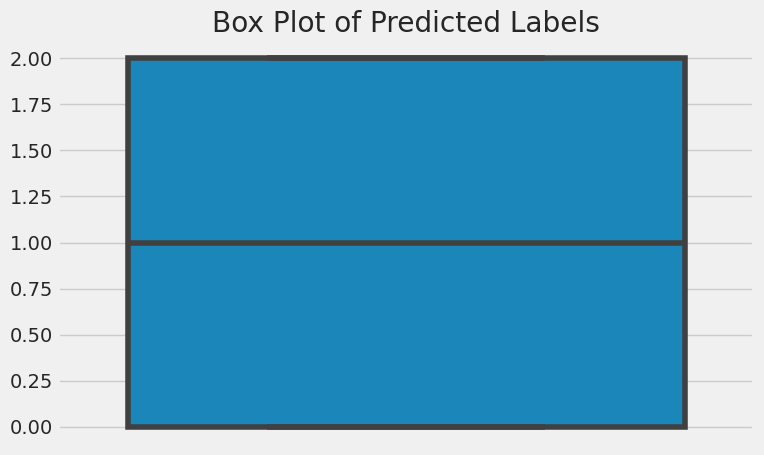

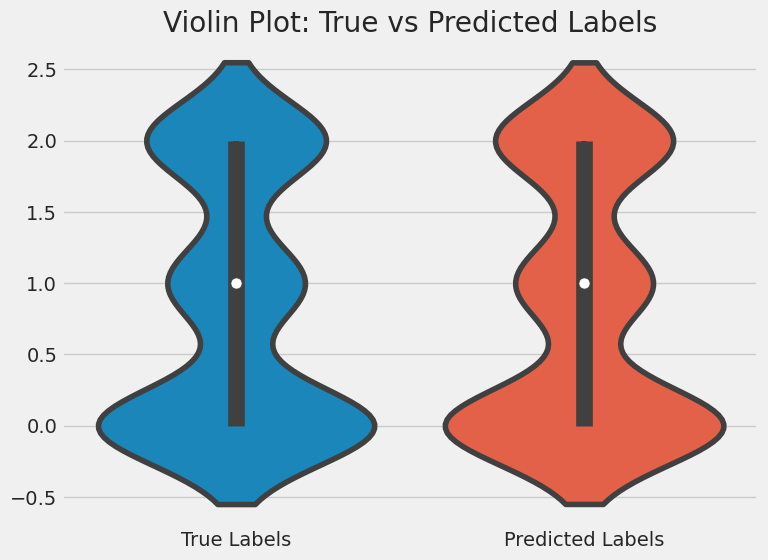

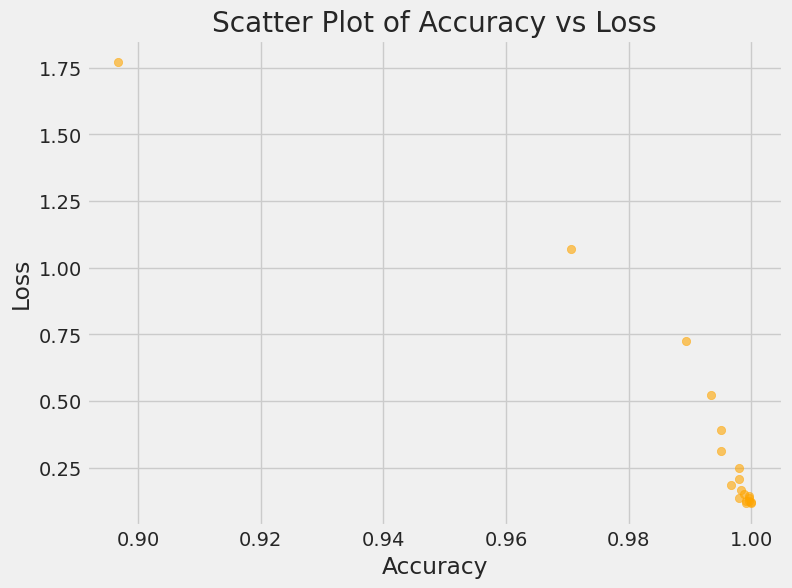

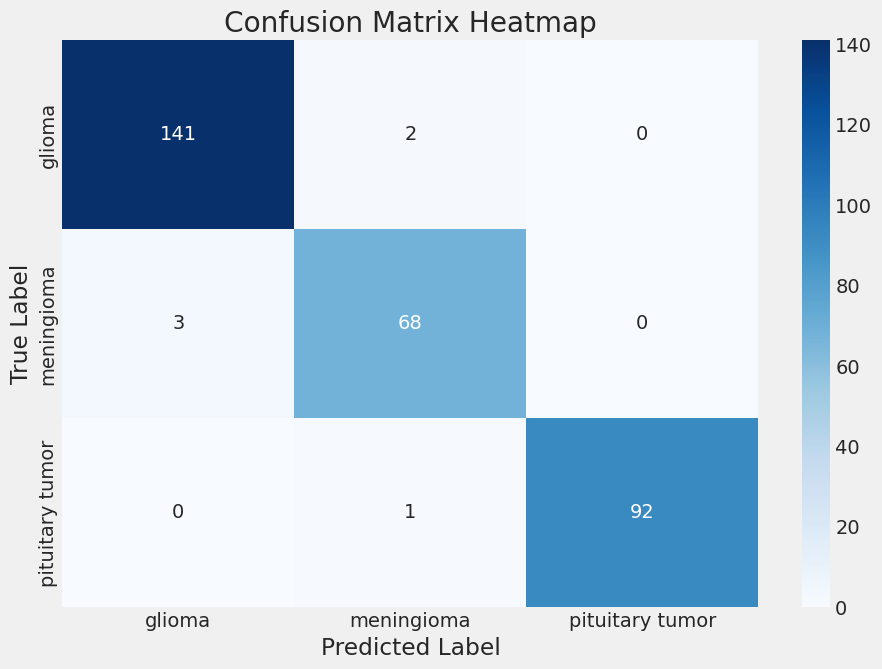

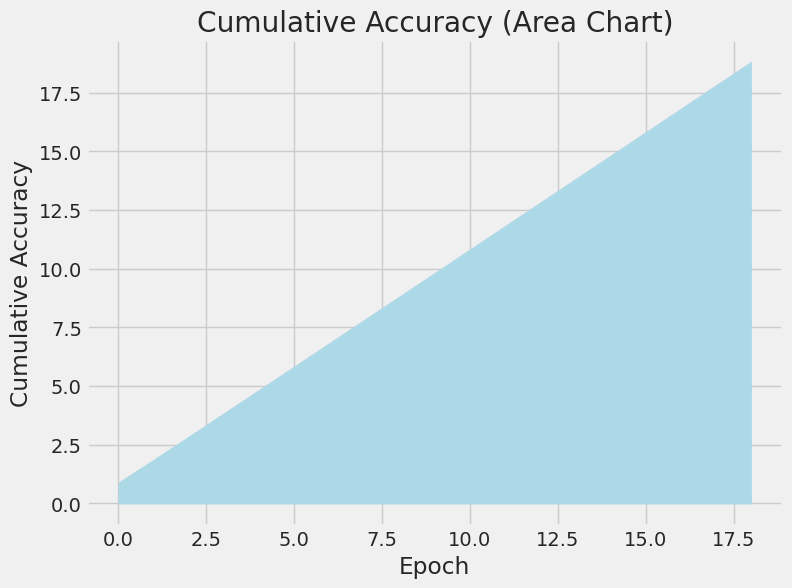

In [125]:
# Plot Line Chart for Accuracy and Loss over epochs
plot_line_chart(history)

# Assuming metrics dictionary with precision, recall, f1_score values
metrics = {
    'precision': precision_score(y_true, y_pred, average='weighted'),
    'recall': recall_score(y_true, y_pred, average='weighted'),
    'f1_score': f1_score(y_true, y_pred, average='weighted')
}
plot_bar_chart(metrics)

# Classification report for each class
class_report = classification_report(y_true, y_pred, output_dict=True)
plot_stacked_bar_chart(class_report)

# Plot distribution of predicted probabilities
plot_histogram(y_pred_probs[:, 1])  # Assuming binary classification; adjust for multiclass

# Plot Pie Chart of class distribution
# plot_pie_chart(y_true, classes=list(train_gen.class_indices.keys()))

# Plot Box Plot of predicted labels
plot_box_plot(y_pred)

# Plot Violin Plot comparing true and predicted labels
plot_violin_plot(y_true, y_pred)

# Plot Scatter Plot: Accuracy vs Loss
plot_scatter_plot(history)

# Bubble Chart (you need to provide sample sizes as appropriate)
# sample_sizes = np.bincount(y_true)  # You can adjust based on your data
# plot_bubble_chart(class_report, sample_sizes)

# Plot Confusion Matrix Heatmap
cm = confusion_matrix(y_true, y_pred)
plot_heatmap(cm, classes=list(train_gen.class_indices.keys()))

# Plot ROC Curve (binary classification example)
# plot_roc_curve(y_true, y_pred_probs[:, 1])

# Plot Precision-Recall Curve
# plot_precision_recall_curve(y_true, y_pred_probs[:, 1])

# Plot Area Chart: Cumulative Accuracy
plot_area_chart(history)

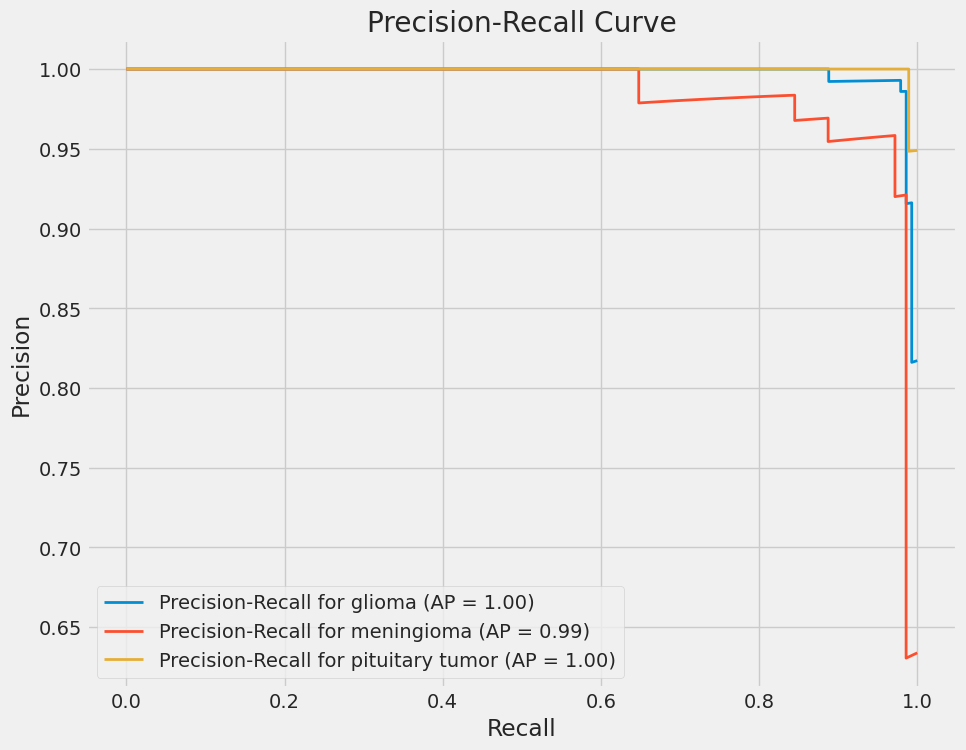

In [126]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np
import matplotlib.pyplot as plt

# Get the true labels and predicted probabilities from the model
y_true = test_gen.classes  # True labels from the test generator
y_probs = preds  # The predictions you already have from ensemble_model.predict(test_gen)

# Ensure the shape of y_probs is appropriate (number of samples, number of classes)
# Initialize the plot
plt.figure(figsize=(10, 8))

# Iterate through each class and plot the Precision-Recall curve
for i, class_name in enumerate(classes):
    # For each class, create binary labels and get predicted probabilities for that class
    y_true_binary = np.array([1 if label == i else 0 for label in y_true])
    y_prob_class = y_probs[:, i]  # Predicted probabilities for the current class
    
    # Compute precision and recall
    precision, recall, _ = precision_recall_curve(y_true_binary, y_prob_class)
    
    # Compute average precision score for the class
    avg_precision = average_precision_score(y_true_binary, y_prob_class)
    
    # Plot the Precision-Recall curve
    plt.plot(recall, precision, lw=2, label=f'Precision-Recall for {class_name} (AP = {avg_precision:.2f})')

# Final plot details
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()


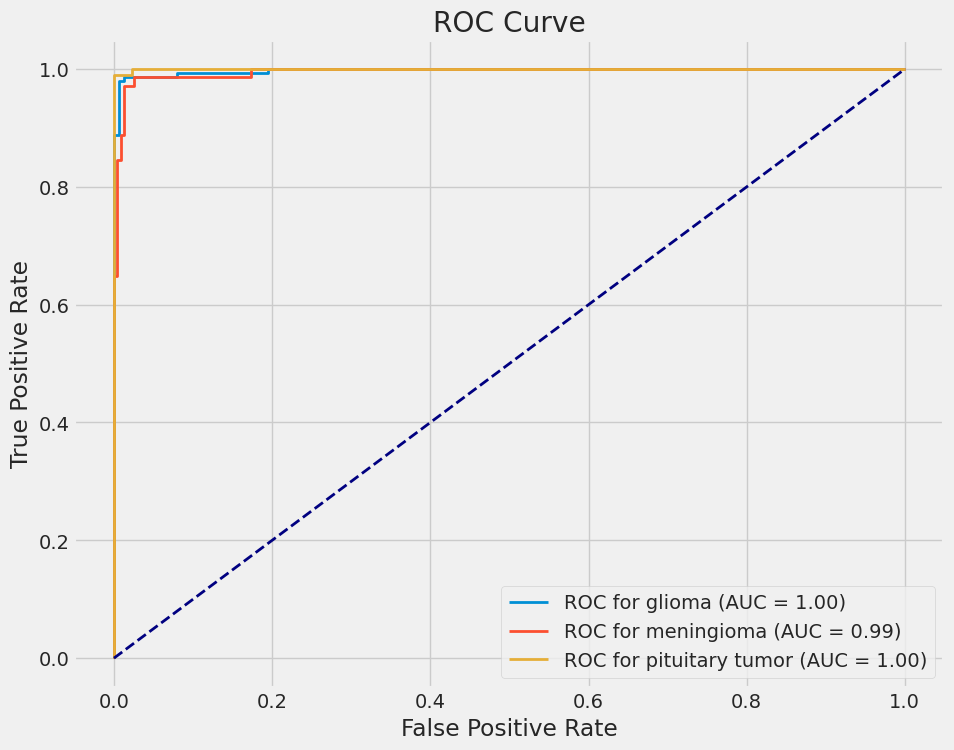

In [127]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

# Get the true labels and predicted probabilities
y_true = test_gen.classes  # True labels from the test generator
y_probs = preds  # Predicted probabilities from the model (from ensemble_model.predict(test_gen))

# Initialize the plot for ROC curves
plt.figure(figsize=(10, 8))

# Iterate through each class and plot ROC curve
for i, class_name in enumerate(classes):
    # Create binary labels for each class
    y_true_binary = np.array([1 if label == i else 0 for label in y_true])
    y_prob_class = y_probs[:, i]  # Get predicted probabilities for the current class
    
    # Compute ROC curve and ROC AUC score
    fpr, tpr, _ = roc_curve(y_true_binary, y_prob_class)
    roc_auc = roc_auc_score(y_true_binary, y_prob_class)
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'ROC for {class_name} (AUC = {roc_auc:.2f})')

# Final plot details
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()


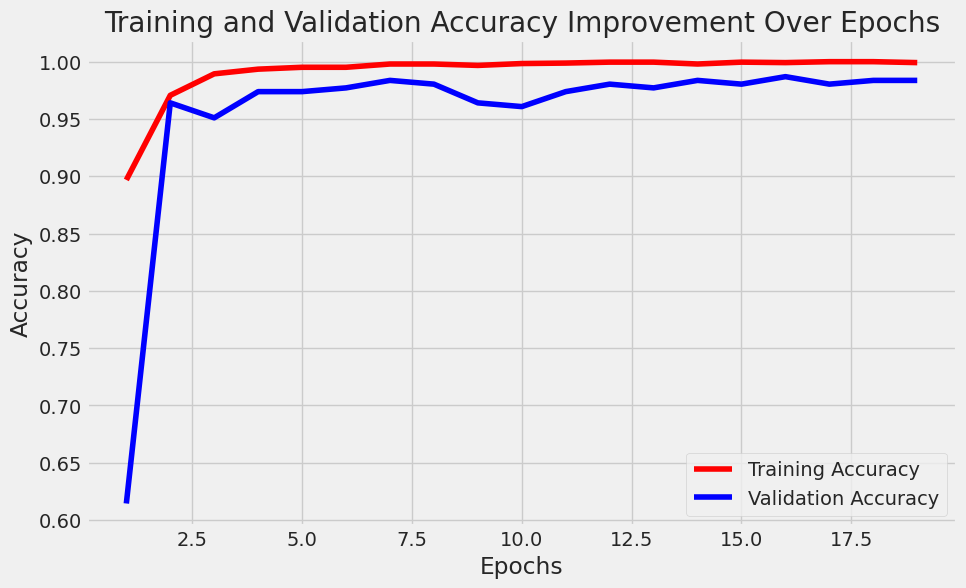

In [128]:
import matplotlib.pyplot as plt

# Extract training and validation accuracy from the history object
train_acc = history.history['accuracy']  # Training accuracy per epoch
val_acc = history.history['val_accuracy']  # Validation accuracy per epoch

# Create a list of epochs for the x-axis
epochs = range(1, len(train_acc) + 1)

# Plot the training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')

# Add title and labels
plt.title('Training and Validation Accuracy Improvement Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()


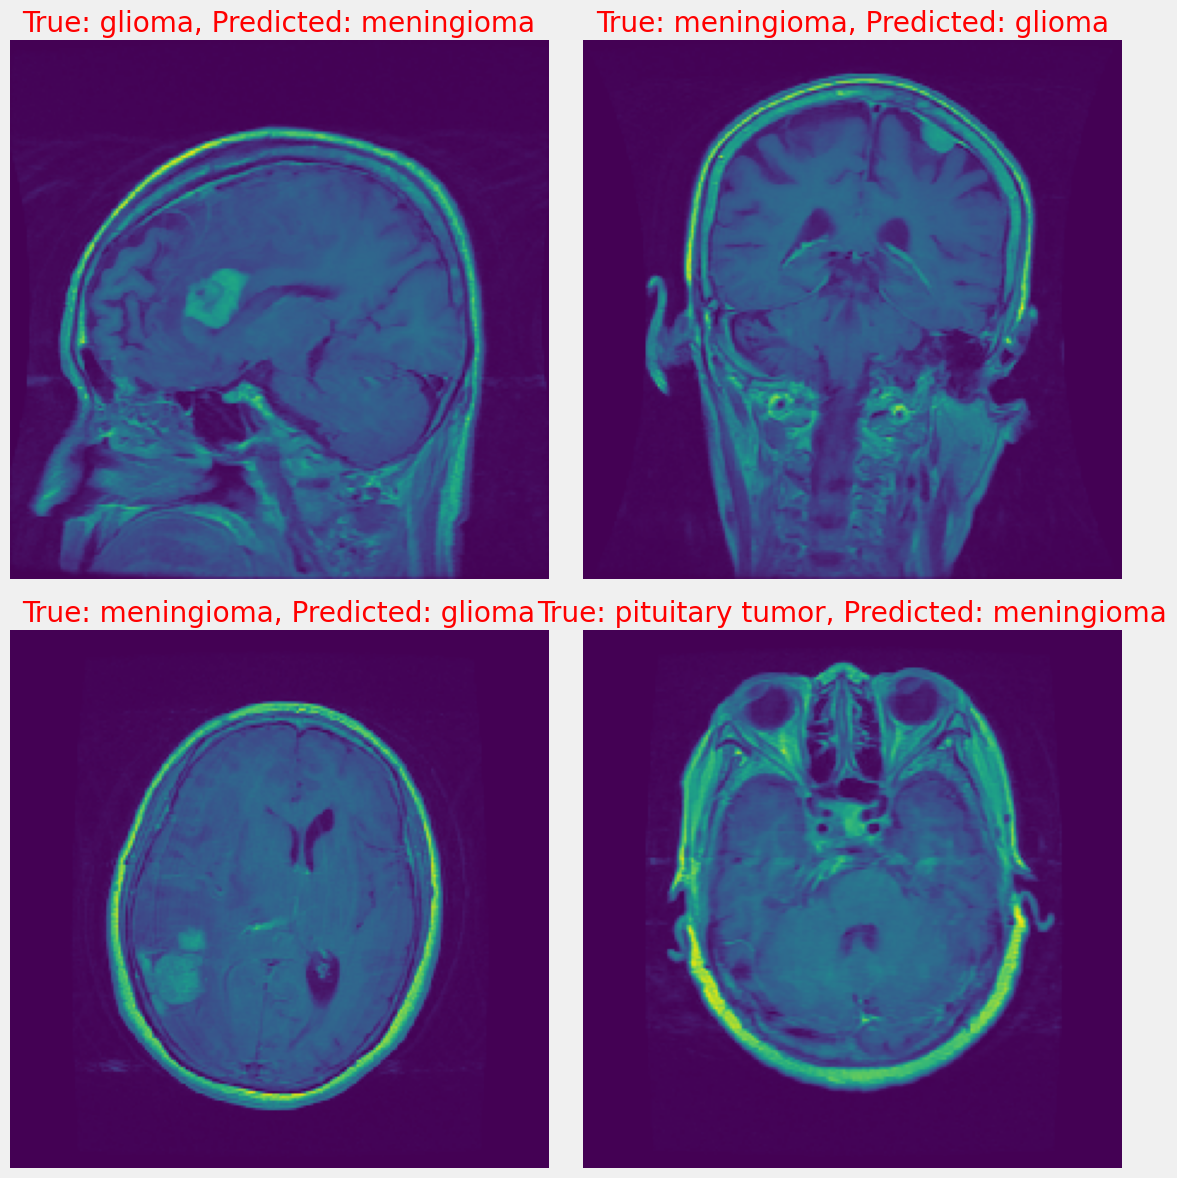

In [129]:
import numpy as np
import matplotlib.pyplot as plt

# Get the true labels and predictions
y_true = test_gen.classes  # True labels
y_pred = np.argmax(preds, axis=1)  # Predicted labels

# Retrieve misclassified indices
misclassified_idx = np.where(y_true != y_pred)[0]

# Display at least 4 misclassified images (or fewer if less than 4 exist)
num_misclassified = len(misclassified_idx)
num_to_display = min(4, num_misclassified)  # Display at least 4 misclassified instances or fewer

# Get the class labels from the generator
classes = list(test_gen.class_indices.keys())

# Create the plot
plt.figure(figsize=(12, 12))
for i in range(num_to_display):
    idx = misclassified_idx[i]
    image = test_gen[idx][0]  # Extract the image from the test generator
    true_label = classes[y_true[idx]]  # True label
    predicted_label = classes[y_pred[idx]]  # Predicted label

    # Plot each misclassified image
    plt.subplot(2, 2, i + 1)
    plt.imshow(image[0] / 255.0)  # Rescale pixel values between 0 and 1
    plt.title(f'True: {true_label}, Predicted: {predicted_label}', color='red')
    plt.axis('off')

plt.tight_layout()
plt.show()


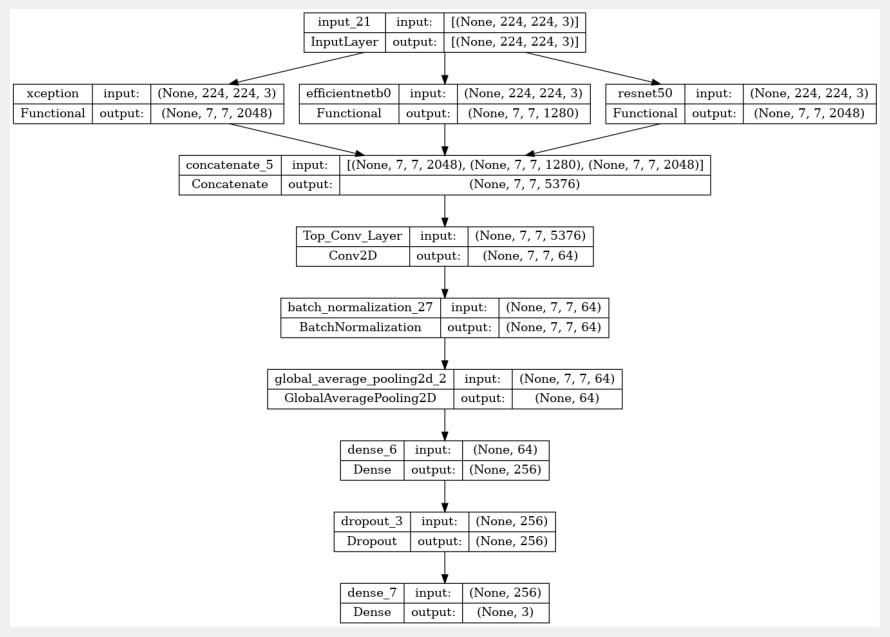

In [130]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture to a file
plot_model(ensemble_model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the saved model architecture image
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open('model_architecture.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()
